In [1]:
import os
import math
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def BasicBlock(inputs, filter_num, training=None, stride=1, **kwargs):
  
  if stride != 1:
    downsample = tf.keras.Sequential()
    downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                          kernel_size=(1, 1),
                                          strides=stride))
    downsample.add(tf.keras.layers.BatchNormalization())
  else:
    downsample = tf.keras.layers.Lambda(lambda x: x)

  residual = downsample(inputs)

  x = tf.keras.layers.Conv2D(filters=filter_num,
                             kernel_size=(3, 3),
                             strides=stride,
                             padding="same")(inputs)
  x = tf.keras.layers.BatchNormalization()(x, training=training)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2D(filters=filter_num,
                             kernel_size=(3, 3),
                             strides=1,
                             padding="same",
                             activation="relu")(x)
  x = tf.keras.layers.BatchNormalization()(x, training=training)

  x = tf.keras.layers.Add()([residual, x])
  output = tf.keras.layers.Activation('relu')(x)
  
  return output

In [3]:
def BottleNeck(inputs, filter_num, training=None, stride=1, **kwargs):
 
    downsample = tf.keras.Sequential()
    downsample.add(tf.keras.layers.Conv2D(filters=filter_num * 4,
                                          kernel_size=(1, 1),
                                          strides=stride))
    downsample.add(tf.keras.layers.BatchNormalization())
   
    residual = downsample(inputs)

    x = tf.keras.layers.Conv2D(filters=filter_num,
                               kernel_size=(1, 1),
                               strides=1,
                               padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters=filter_num,
                               kernel_size=(3, 3),
                               strides=stride,
                               padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters=filter_num * 4,
                               kernel_size=(1, 1),
                               strides=1,
                               padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x, training=training)

    x = tf.keras.layers.Add()([residual, x])
    output = tf.keras.layers.Activation('relu')(x)

    return output

In [4]:
def make_basic_block_layer(x, filter_num, blocks, training, stride=1):

    x = BasicBlock(x, filter_num, training, stride=stride)
    for _ in range(1, blocks):
        x = BasicBlock(x, filter_num, training, stride=1)

    return x

In [5]:
def make_bottleneck_layer(filter_num, blocks, stride=1):
    
    x = BottleNeck(x, filter_num, training, stride=stride)

    for _ in range(1, blocks):
        x = BottleNeck(x, filter_num, training, stride=1)

    return res_block

In [6]:
def ResNetTypeI(layer_params, training=None, mask=None):
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))
    x = tf.keras.layers.Conv2D(filters=64,
                               kernel_size=(7, 7),
                               strides=2,
                               padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                  strides=2,
                                  padding="same")(x)
    x = make_basic_block_layer(x, filter_num=64,  blocks=layer_params[0], training=training)
    x = make_basic_block_layer(x, filter_num=128, blocks=layer_params[1], training=training, stride=2)
    x = make_basic_block_layer(x, filter_num=256, blocks=layer_params[2], training=training, stride=2)
    x = make_basic_block_layer(x, filter_num=512, blocks=layer_params[3], training=training, stride=2)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output = tf.keras.layers.Dense(units=NUM_CLASSES, activation=tf.keras.activations.softmax)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=output, name='Resnet34')
    
    return model

In [7]:
def ResNetTypeII(layer_params, training=None, mask=None):

    inputs = tf.keras.layers.Input(shape=(32, 32, 3))
    x = tf.keras.layers.Conv2D(filters=64,
                               kernel_size=(7, 7),
                               strides=2,
                               padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x, training=training)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                  strides=2,
                                  padding="same")(x)
    x = make_bottleneck_layer(x, filter_num=64,  blocks=layer_params[0], training=training)
    x = make_bottleneck_layer(x, filter_num=128, blocks=layer_params[1], training=training, stride=2)
    x = make_bottleneck_layer(x, filter_num=256, blocks=layer_params[2], training=training, stride=2)
    x = make_bottleneck_layer(x, filter_num=512, blocks=layer_params[3], training=training, stride=2)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output = tf.keras.layers.Dense(units=NUM_CLASSES, activation=tf.keras.activations.softmax)(x)

    model = tf.keras.Model(inputs=inputs, outputs=output, name='Resnet34')

    return model

In [8]:
def resnet_34():
  return ResNetTypeI(layer_params=[3, 4, 6, 3])

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [10]:
def scheduler(epoch):
  
  initial_lrate = (10 ** -3)
  k = 0.1
  lrate = initial_lrate * math.exp(-k * (epoch))
  
  return lrate

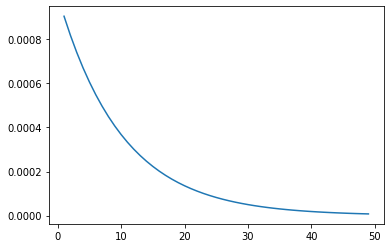

In [11]:
epochs = [i for i in range(1, 50, 1)]
lrate = [scheduler(i) for i in range(1, 50, 1)]
plt.plot(epochs, lrate)

In [12]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [13]:
EPOCHS = 50
NUM_CLASSES = 10

In [14]:
x_train, x_test = x_train / 255.0, x_test / 255.0
model = resnet_34()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
model.compile(optimizer = optimizer, loss=loss_object, metrics=train_accuracy)

In [15]:
history = model.fit(x = x_train, y = y_train, epochs = EPOCHS, validation_data=(x_test, y_test), callbacks=[callback])

Epoch 1/50
1563/1563 [==============================] - 93s 37ms/step - loss: 1.7507 - train_accuracy: 0.3944 - val_loss: 1.8408 - val_train_accuracy: 0.3510
Epoch 2/50
1563/1563 [==============================] - 57s 37ms/step - loss: 1.3562 - train_accuracy: 0.5317 - val_loss: 2.4661 - val_train_accuracy: 0.4132
Epoch 3/50
1563/1563 [==============================] - 59s 38ms/step - loss: 1.1448 - train_accuracy: 0.6097 - val_loss: 1.4508 - val_train_accuracy: 0.5024
Epoch 4/50
1563/1563 [==============================] - 57s 37ms/step - loss: 0.9643 - train_accuracy: 0.6677 - val_loss: 1.6032 - val_train_accuracy: 0.5392
Epoch 5/50
1563/1563 [==============================] - 57s 37ms/step - loss: 0.8585 - train_accuracy: 0.7063 - val_loss: 0.8814 - val_train_accuracy: 0.7009
Epoch 6/50
1563/1563 [==============================] - 57s 37ms/step - loss: 0.7700 - train_accuracy: 0.7403 - val_loss: 1.1373 - val_train_accuracy: 0.6248
Epoch 7/50
1563/1563 [==============================

In [16]:
history_dict = history.history

loss = history_dict["loss"]
train_accuracy = history_dict["train_accuracy"]
val_loss = history_dict["val_loss"]
val_train_accuracy = history_dict["val_train_accuracy"]

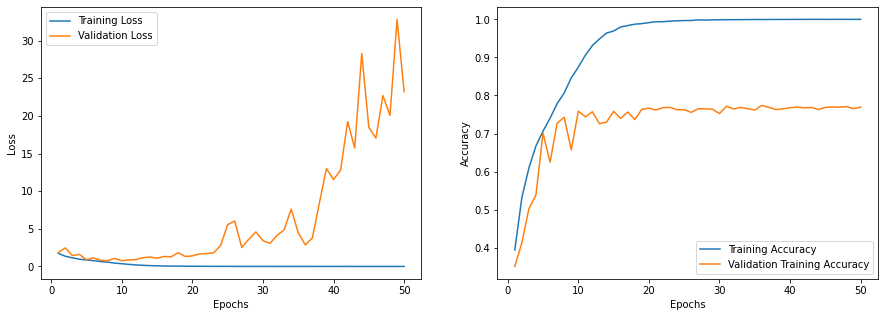

In [17]:
epochs = range(1, len(loss) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, train_accuracy, label = "Training Accuracy")
ax2.plot(epochs, val_train_accuracy, label = "Validation Training Accuracy")
ax2.set(xlabel = "Epochs", ylabel = "Accuracy")
ax2.legend()

plt.show()

In [18]:
model.save("resnet-34")

INFO:tensorflow:Assets written to: resnet-34/assets
